## Import Dependencies

In [36]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from pymoo.model.problem import FunctionalProblem
from pymoo.model.problem import ConstraintsAsPenaltyProblem
from pymoo.algorithms.so_pso import PSO
from pymoo.optimize import minimize
from pymoo.model.callback import Callback
from pymoo.algorithms.so_de import DE
from pymoo.factory import get_problem
from pymoo.operators.sampling.latin_hypercube_sampling import LatinHypercubeSampling
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.optimize import minimize

### Scrape Data from Yahoo

In [4]:
test = data.DataReader(['TSLA', 'FB','ARKG','DIS','SPCE','PTON'], 'yahoo', start='2020/1/1', end='2021/2/28')
test.head()

Attributes  Adj Close                                                   \
Symbols          TSLA          FB       ARKG         DIS   SPCE   PTON   
Date                                                                     
2019-12-31  83.666000  205.250000  33.259415  144.630005  11.55  28.40   
2020-01-02  86.052002  209.779999  33.090733  148.199997  11.79  29.74   
2020-01-03  88.601997  208.669998  32.425945  146.500000  11.81  30.60   
2020-01-06  90.307999  212.600006  32.818867  145.649994  11.38  29.75   
2020-01-07  93.811996  213.059998  33.090733  145.699997  11.36  30.40   

Attributes      Close                                     ...       Open  \
Symbols          TSLA          FB       ARKG         DIS  ...       ARKG   
Date                                                      ...              
2019-12-31  83.666000  205.250000  33.520000  144.630005  ...  33.290001   
2020-01-02  86.052002  209.779999  33.349998  148.199997  ...  34.000000   
2020-01-03  88.601997  208.669998  32.680000  146.500000  ...  32.730000   
2020-01-06  90.307999  212.600006  33.076000  145.649994  ...  32.470001   
2020-01-07  93.811996  213.059998  33.349998  145.699997  ...  33.169998   

Attributes                                    Volume                        \
Symbols            DIS   SPCE       PTON        TSLA          FB      ARKG   
Date                                                                         
2019-12-31  143.669998  11.32  27.480000  51428500.0   8953500.0  408400.0   
2020-01-02  145.289993  11.70  28.900000  47660500.0  12077100.0  264900.0   
2020-01-03  146.399994  11.54  29.490000  88892500.0  11188400.0  188800.0   
2020-01-06  145.539993  11.81  30.610001  50665000.0  17058900.0  116400.0   
2020-01-07  145.990005  11.40  29.440001  89410500.0  14912400.0  105300.0   

Attributes                                   
Symbols           DIS       SPCE       PTON  
Date                                         
2019-12-31  5662900.0  2030100.0  3601700.0  
2020-01-02  9502100.0  3920700.0  5916200.0  
2020-01-03  7320200.0  2311800.0  4974100.0  
2020-01-06  8262500.0  3100700.0  4028900.0  
2020-01-07  6906500.0  1718500.0  3072000.0  

[5 rows x 36 columns]

### Data Visualization

<Figure size 432x288 with 0 Axes>

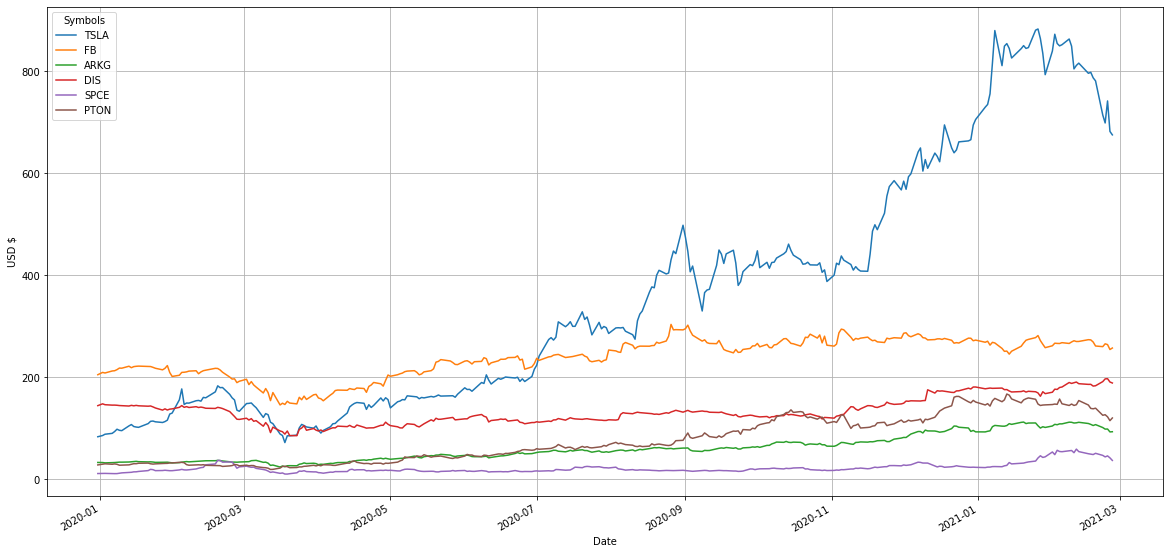

In [6]:
dfClose = test['Adj Close'] 
plt.figure()
dfClose.plot(subplots=False,figsize=(20,10),grid=True,xlabel='Date',ylabel='USD $',legend=True)
plt.show()

### Covariance Matrix and Returns

In [8]:
cov_matrix = dfClose.pct_change().apply(lambda x: np.log(1+x)).cov()
returns = dfClose.pct_change()
cov_matrix

Symbols,TSLA,FB,ARKG,DIS,SPCE,PTON
Symbols,,,,,,
TSLA,0.002974,0.000633,0.000897,0.000515,0.001376,0.000368
FB,0.000633,0.000782,0.000483,0.000408,0.000523,0.000191
ARKG,0.000897,0.000483,0.001025,0.000406,0.000909,0.000438
DIS,0.000515,0.000408,0.000406,0.000870,0.000652,-0.000008
SPCE,0.001376,0.000523,0.000909,0.000652,0.004926,0.000069
PTON,0.000368,0.000191,0.000438,-0.000008,0.000069,0.002175


## Monte-Carlo Method

Portfolio with maximum Sharpe Ratio is:  Pft Returns                                              1.935616
Pft Risk                                                  0.57605
Sharpe Ratio                                              3.36015
Pft Weights     [0.38937863644561077, 0.006364755050725324, 0....
Name: 402, dtype: object
Portfolio with minimum Risk is:  Pft Returns                                              0.815676
Pft Risk                                                 0.384683
Sharpe Ratio                                             2.120386
Pft Weights     [0.008982315020777747, 0.26650850168824447, 0....
Name: 318, dtype: object
Portfolio with maximum Revenue is:  Pft Returns                                              2.088651
Pft Risk                                                 0.745519
Sharpe Ratio                                             2.801608
Pft Weights     [0.7183058832346308, 0.013822391737002537, 0.0...
Name: 4163, dtype: object


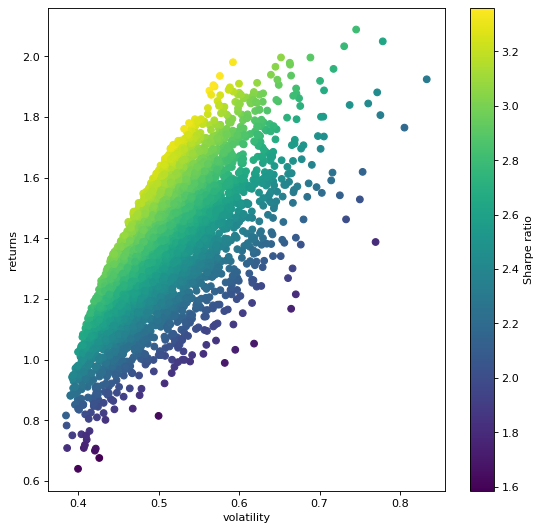

In [22]:
def rand_weights(n):
    ''' Produces n uniformly random distributed weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)
def random_portfolio(returns):
    '''
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_assets = len(dfClose.columns)
n_obs = 100

numberPft = 5000
numberOfTradingDays = len(dfClose)
portfolioReturns = []
portfolioRisk = []
portfolioSR = []
portfolioWeights = []

for pft in range(numberPft):
    # returns
    weights = rand_weights(n_assets)
    totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
    portfolioReturns.append(totalReturns)
    # variance
    covarianceMatrix = returns.cov()*numberOfTradingDays
    pftVariance = np.dot(weights.T, np.dot(covarianceMatrix,weights))
    pftStdDev = np.sqrt(pftVariance)
    portfolioRisk.append(pftStdDev)
    # Sharpe Ratio
    sr = (totalReturns-0)/pftStdDev
    portfolioSR.append(sr)
    portfolioWeights.append(weights)

portfolioReturns = np.array(portfolioReturns)
portfolioRisk = np.array(portfolioRisk)
portfolioSR = np.array(portfolioSR)

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(portfolioRisk,portfolioReturns,c=portfolioReturns/portfolioRisk)
plt.xlabel('volatility')
plt.ylabel('returns')
plt.colorbar(label='Sharpe ratio')

portfolioMetric = [portfolioReturns,portfolioRisk,portfolioSR,portfolioWeights]
dfPft = pd.DataFrame(portfolioMetric)
dfPft = dfPft.T
dfPft.columns = ['Pft Returns','Pft Risk','Sharpe Ratio','Pft Weights']
for elem in dfPft.columns[0:3]:
    dfPft[elem] = dfPft[elem].astype(float)
maxSR = dfPft.iloc[dfPft['Sharpe Ratio'].idxmax()]
minRisk = dfPft.iloc[dfPft['Pft Risk'].idxmin()]
maxRev = dfPft.iloc[dfPft['Pft Returns'].idxmax()]

print("Portfolio with maximum Sharpe Ratio is: " ,maxSR)
print("Portfolio with minimum Risk is: " ,minRisk)
print("Portfolio with maximum Revenue is: " ,maxRev)

## Genetic Algorithms

### Particle Swarm Optimization

In [24]:
def fitnessFunction(weights):
    numberTradingDays = len(returns)
    weights = np.array(weights)
    tickerList = ['TSLA', 'FB','ARKG','DIS','SPCE','PTON']
    totalReturns = np.sum(returns.mean()*weights)*numberTradingDays
    covMatrix = returns.cov()*numberTradingDays
    pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
    pftStd = np.sqrt(pftVar)
    sr = totalReturns/pftStd
    return -sr

constr_ieq = []

constr_eq = [lambda weights: 1-weights[0]-weights[1]-weights[2]-weights[3]-weights[4]-weights[5]]

problem = FunctionalProblem(6,
                            fitnessFunction,
                            xl=0,
                            xu=1,
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq
                            )

problem = ConstraintsAsPenaltyProblem(problem, penalty=1e6)

class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.n_evals = []
        self.opt = []

    def notify(self, algorithm):
        self.n_evals.append(algorithm.evaluator.n_eval)
        self.opt.append(algorithm.opt[0].F)

algorithm = PSO(pop_size=100)
callback = MyCallback()

res = minimize(problem, algorithm, termination=('n_gen', 300),callback=callback, seed=1,save_history=True)

opt = res.opt[0]
X, F, CV = opt.get("X", "__F__", "__CV__")

print("Best solution found: \nX = %s\nF = %s\nCV = %s\n" % (X, F, CV))
opt = res.opt[0]
weights = opt.X
totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
covMatrix = returns.cov()*numberOfTradingDays
pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
pftStd = np.sqrt(pftVar)
print("The PSO portfolio has a risk of :", pftStd)
print("The PSO portfolio has a return of :", totalReturns)
print("The PSO portfolio has a Sharpe Ratio of :", totalReturns/pftStd)

Best solution found: 
X = [0.01483441 0.0016987  0.02311295 0.1717502  0.33954401 0.44905875]
F = [-2.67331437]
CV = [0.]

The PSO portfolio has a risk of : 0.5886126367304876
The PSO portfolio has a return of : 1.5735466214505367
The PSO portfolio has a Sharpe Ratio of : 2.673314372234635


#### PSO Pareto Frontier

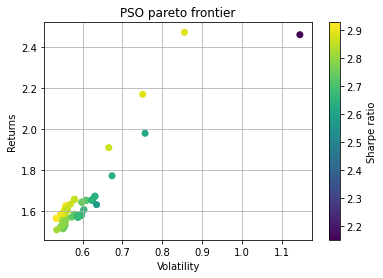

In [26]:
returnStore = []
riskStore = []
for i in range(len(res.history)):
  weights = res.history[i].opt[0].X
  totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
  covMatrix = returns.cov()*numberOfTradingDays
  pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
  pftStd = np.sqrt(pftVar)
  returnStore.append(totalReturns)
  riskStore.append(pftStd)

riskStore = np.array(riskStore)
returnStore = np.array(returnStore)
plt.scatter(riskStore,returnStore,c=returnStore/riskStore)
plt.grid()
plt.title('PSO pareto frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')
plt.show()


#### Convergence of PSO

Text(0, 0.5, 'Sharpe Ratio')

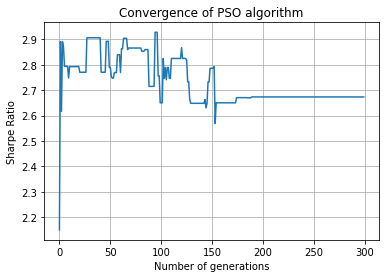

In [28]:
storePSO = []
for i in range(len(res.history)):
  weights = res.history[i].opt[0].X
  storePSO.append(-fitnessFunction(weights))
plt.grid()
plt.plot(range(len(storePSO)),storePSO)
plt.title('Convergence of PSO algorithm')
plt.xlabel('Number of generations')
plt.ylabel('Sharpe Ratio')

### Differential Evolution Optimization

In [37]:
algorithm = DE(
    pop_size=100,
    sampling=LatinHypercubeSampling(iterations=300, criterion="maxmin"),
    variant="DE/rand/1/bin",
    CR=0.5,
    F=0.3,
    dither="vector",
    jitter=False
)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 300),
               seed=1,
               verbose=False,
               save_history=True)

opt = res.opt[0]
weights = opt.X
totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
covMatrix = returns.cov()*numberOfTradingDays
pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
pftStd = np.sqrt(pftVar)
print("The DE portfolio has a risk of :", pftStd)
print("The DE portfolio has a return of :", totalReturns)
print("The DE portfolio has a Sharpe Ratio of :", totalReturns/pftStd)

The DE portfolio has a risk of : 0.4818490298946168
The DE portfolio has a return of : 1.181071172908533
The DE portfolio has a Sharpe Ratio of : 2.45112286138013


#### DE Pareto Frontier

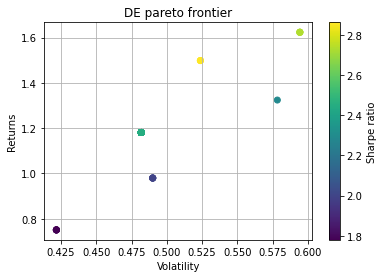

In [33]:
returnStore = []
riskStore = []
for i in range(len(res.history)):
  weights = res.history[i].opt[0].X
  totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
  covMatrix = returns.cov()*numberOfTradingDays
  pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
  pftStd = np.sqrt(pftVar)
  returnStore.append(totalReturns)
  riskStore.append(pftStd)

riskStore = np.array(riskStore)
returnStore = np.array(returnStore)
plt.scatter(riskStore,returnStore,c=returnStore/riskStore)
plt.grid()
plt.title('DE pareto frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')
plt.show()


#### Convergence of DE

Text(0, 0.5, 'Sharpe Ratio')

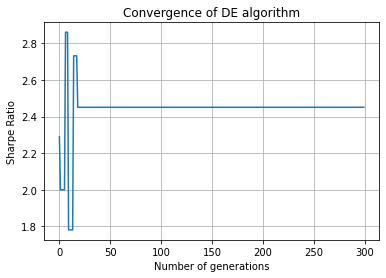

In [34]:
storeDE = []
for i in range(len(res.history)):
  weights = res.history[i].opt[0].X
  storeDE.append(-fitnessFunction(weights))
plt.grid()
plt.plot(range(len(storeDE)),storeDE)
plt.title('Convergence of DE algorithm')
plt.xlabel('Number of generations')
plt.ylabel('Sharpe Ratio')

### NSGAII Optimization

In [43]:
def fitnessFunction(weights):
    numberTradingDays = len(returns)
    weights = np.array(weights)
    tickerList = ['TSLA', 'FB','ARKG','DIS','SPCE','PTON']
    totalReturns = np.sum(returns.mean()*weights)*numberTradingDays
    covMatrix = returns.cov()*numberTradingDays
    pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
    pftStd = np.sqrt(pftVar)
    sr = totalReturns/pftStd
    return -sr

numberTradingDays = len(returns)
objs = [
        lambda weights: -np.sum(returns.mean()*weights)*numberTradingDays,
        lambda weights: np.sqrt(np.dot(weights.T, np.dot(returns.cov()*numberTradingDays,weights)))
]

constr_ieq = []

constr_eq = [lambda weights: 1-sum(weights)]

problem = FunctionalProblem(6,
                            objs,
                            xl=0,
                            xu=1,
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq
                            )

problem = ConstraintsAsPenaltyProblem(problem, penalty=1e6)

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 300),
               seed=1,
               save_history=True,
               verbose=False)

storeNSGAII = []
for i in range(len(res.history)):
    weights = res.history[i].opt[0].X
    storeNSGAII.append(-fitnessFunction(weights))
    

opt = res.opt[0]
weights = opt.X
totalReturns = np.sum(returns.mean()*weights)*numberOfTradingDays
covMatrix = returns.cov()*numberOfTradingDays
pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
pftStd = np.sqrt(pftVar)
print("The NSGAII portfolio has a risk of :", pftStd)
print("The NSGAII portfolio has a return of :", totalReturns)
print("The NSGAII portfolio has a Sharpe Ratio of :", totalReturns/pftStd)

The NSGAII portfolio has a risk of : 0.5398170128608325
The NSGAII portfolio has a return of : 1.4651161932237506
The NSGAII portfolio has a Sharpe Ratio of : 2.714097848563852


#### NSGAII Pareto Frontier

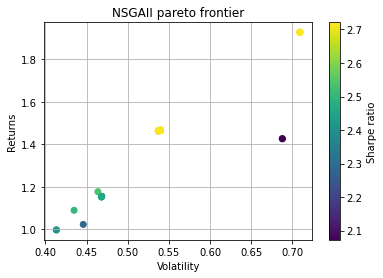

In [44]:
returnStore = []
riskStore = []
for i in range(len(res.history)):
    weights = res.history[i].opt[0].X
    totalReturns = np.sum(returns.mean()*weights)*numberTradingDays
    covMatrix = returns.cov()*numberTradingDays
    pftVar = np.dot(weights.T, np.dot(covMatrix,weights))
    pftStd = np.sqrt(pftVar)
    returnStore.append(totalReturns)
    riskStore.append(pftStd)

riskStore = np.array(riskStore)
returnStore = np.array(returnStore)
plt.scatter(riskStore,returnStore,c=returnStore/riskStore)
plt.grid()
plt.title('NSGAII pareto frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')
plt.show()


#### NSGAII Convergence

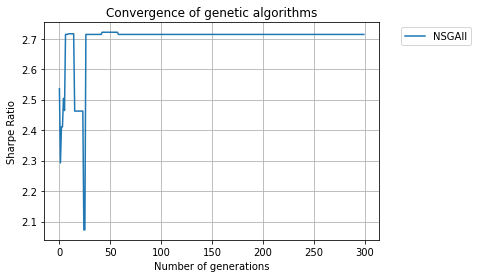

In [46]:
#plt.figure(figsize=(12,10))
plt.plot(range(len(storeNSGAII)),storeNSGAII,label='NSGAII')
plt.title('Convergence of genetic algorithms')
plt.xlabel('Number of generations')
plt.grid()
plt.ylabel('Sharpe Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
plt.show()

## Comparison of GA's convergence

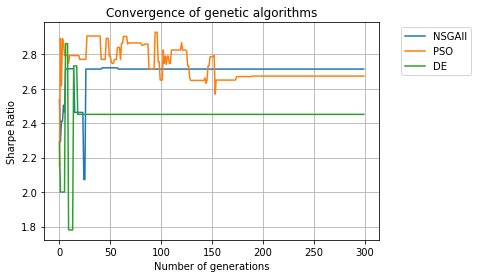

In [47]:
#plt.figure(figsize=(12,10))
plt.plot(range(len(storeNSGAII)),storeNSGAII,label='NSGAII')
plt.plot(range(len(storePSO)),storePSO,label='PSO')
plt.plot(range(len(storeDE)),storeDE,label='DE')
plt.title('Convergence of genetic algorithms')
plt.xlabel('Number of generations')
plt.grid()
plt.ylabel('Sharpe Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 10})
plt.show()